**Load Data**

In [131]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
import numpy as np
from sklearn.metrics import recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from plotnine import ggplot, aes, geom_line, geom_abline, labs

In [132]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [133]:
ha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB


In [134]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


The dataset consists of clinical data from patients who entered the hospital complaining of chest pain (“angina”) during exercise. The information collected includes:

age : Age of the patient

sex : Sex of the patient

cp : Chest Pain type

* Value 1: typical angina
* Value 2: atypical angina
* Value 3: non-anginal pain
* Value 4: asymptomatic
* trtbps : resting blood pressure (in mm Hg)

chol : cholesterol in mg/dl fetched via BMI sensor

restecg : resting electrocardiographic results

* Value 0: normal
* Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
* Value 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria
thalach : maximum heart rate achieved during exercise

output : the doctor’s diagnosis of whether the patient is at risk for a heart attack

* 0 = not at risk of heart attack
* 1 = at risk of heart attack

***Part One: Fitting Models***

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

* Find the best model based on ROC AUC for predicting the target variable.

* Report the (cross-validated!) ROC AUC metric.

* Fit the final model.

* Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

* (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

**Q1: KNN**

Find the best model based on ROC AUC for predicting the target variable.

In [135]:
# KNN model AUC

X = ha.drop('output', axis=1)
y = ha['output']

ns=[90,91,89]
knn_auc_list=[]

for n in ns:

    knn_pipeline=Pipeline(
        [
            ("standardize", StandardScaler()),
            ("knc", KNeighborsClassifier(n_neighbors=n))
        ]
    )
    knn_auc=cross_val_score(knn_pipeline, X, y, cv=5, scoring='roc_auc')
    mean_auc_roc = knn_auc.mean()
    knn_auc_list.append(mean_auc_roc)

knn_auc_df=pd.DataFrame({'n': ns, 'AUC': knn_auc_list})
knn_auc_df

,n,AUC
0,90,0.846006
1,91,0.843068
2,89,0.842532


In [136]:
# Fit model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_pipeline=Pipeline(
        [
            ("standardize", StandardScaler()),
            ("knc", KNeighborsClassifier(n_neighbors=90))
        ]
    )

knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('knc', KNeighborsClassifier(n_neighbors=90))])

In [ ]:
# Generate the confusion matrix
y_pred = knn_pipeline.predict(X_test)
knn_cm = confusion_matrix(y_test, y_pred)
print(knn_cm)

[[21  5]
 [13 16]]


**Q2: Logistic Regression**

In [137]:
# Logistic Regression AUC
lr_pipeline=Pipeline(
    [
        ("standardize", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=1000))
    ]
)
log_auc=cross_val_score(lr_pipeline, X, y, cv=5, scoring='roc_auc').mean()
log_auc

0.8533255526083113

In [138]:
# Fit model
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [139]:
# Generate the confusion matrix
y_pred = lr_pipeline.predict(X_test)
lr_cm = confusion_matrix(y_test, y_pred)
print(lr_cm)

[[20  6]
 [14 15]]


**Q3: Decision Tree**

In [140]:
# Decision Tree AUC
leaves=[34, 35, 36]
dt_auc_list=[]

for leaf in leaves:
    dt_pipeline=Pipeline(
        [
            ("standardize", StandardScaler()),
            ("dtc", DecisionTreeClassifier(min_samples_leaf=leaf))
        ]
    )

    dt_auc=cross_val_score(dt_pipeline, X, y, cv=5, scoring='roc_auc').mean()
    dt_auc_list.append(dt_auc)

dt_auc_df=pd.DataFrame({'leaves': leaves, 'AUC': dt_auc_list})
dt_auc_df

,leaves,AUC
0,34,0.816841
1,35,0.819434
2,36,0.810809


In [141]:
# Fit the Model
dt_pipeline=Pipeline(
        [
            ("standardize", StandardScaler()),
            ("dtc", DecisionTreeClassifier(min_samples_leaf=10))
        ]
    )
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('dtc', DecisionTreeClassifier(min_samples_leaf=10))])

In [143]:
# Generate the confusion matrix
y_pred = lr_pipeline.predict(X_test)
dt_cm = confusion_matrix(y_test, y_pred)
print(dt_cm)

[[20  6]
 [14 15]]


**Q4: Interpretation**

Which predictors were most important to predicting heart attack risk?

In [144]:
decision_tree = dt_pipeline.named_steps['dtc']
importances = decision_tree.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances_sorted

,Feature,Importance
2,cp,0.530554
6,thalach,0.228432
1,sex,0.146406
0,age,0.066303
4,chol,0.018822
3,trtbps,0.009483
5,restecg,0.000000


By accessing the decision tree classifier using the step named "dtc", then used the "feature_importances_" attribute from the classifier, I was able to identify each features importance as determined by the decision tree.  From doing so, I was able to determine that the most important feature is "cp" which is the predictor for chest pain types.  Clearly, types of chest pain will tell you a lot about your risk of heart disease.

**Q5: ROC Curve**

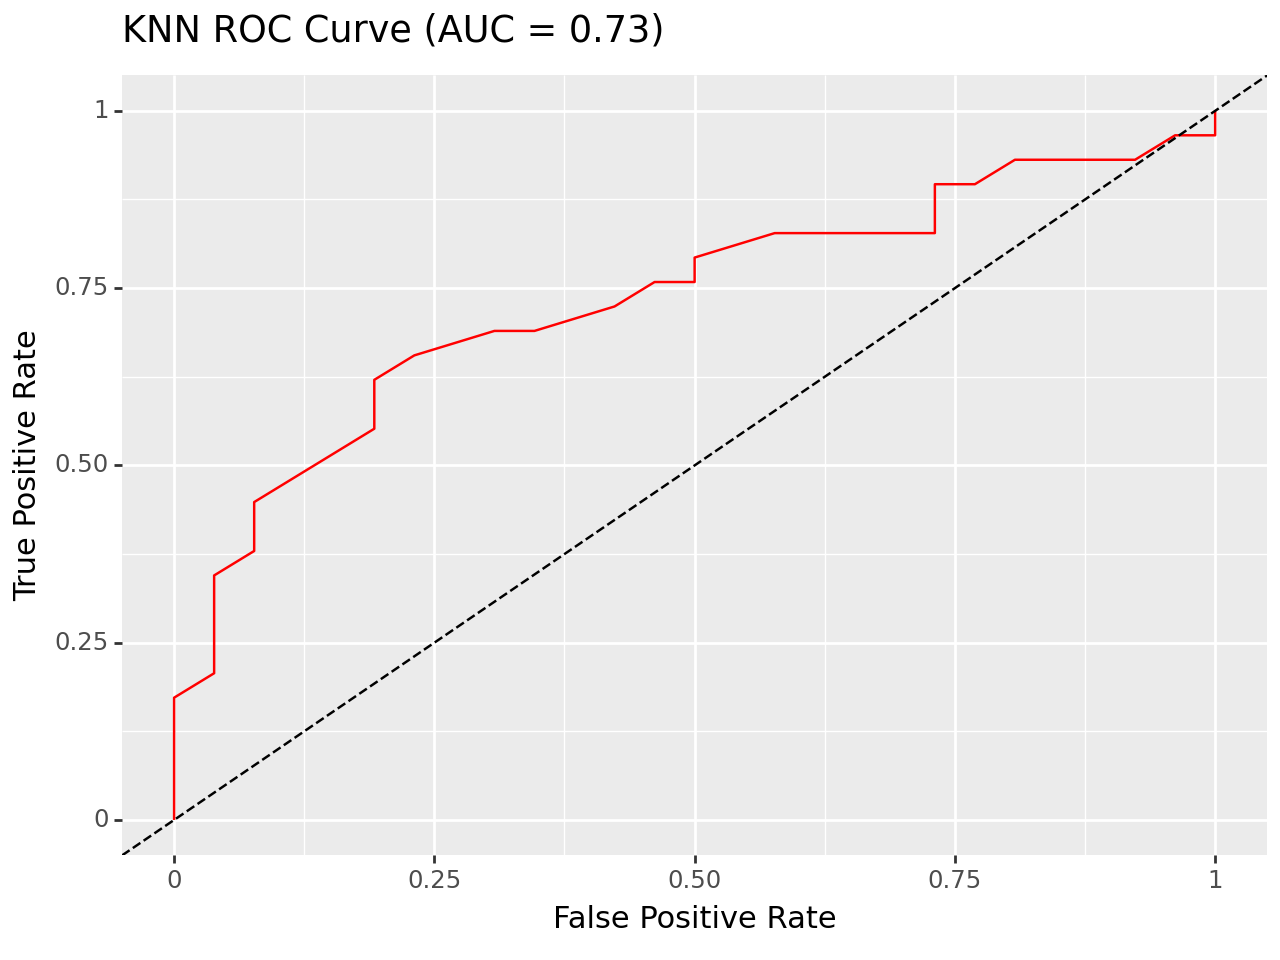

In [145]:
# KNN ROC Curve
y_pred_prob = knn_pipeline.predict_proba(X_test)[:, 1]
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, y_pred_prob)
knn_roc_auc = auc(knn_fpr, knn_tpr)
knn_roc_data = pd.DataFrame({'FPR': knn_fpr, 'TPR': knn_tpr})

# Plot Curve
knn_roc_plot = (
    ggplot(knn_roc_data, aes(x='FPR', y='TPR')) +
    geom_line(color="red") +
    geom_abline(linetype='dashed') +
    labs(title='KNN ROC Curve (AUC = {})'.format(round(knn_roc_auc, 2)), x='False Positive Rate', y='True Positive Rate')
)

print(knn_roc_plot)

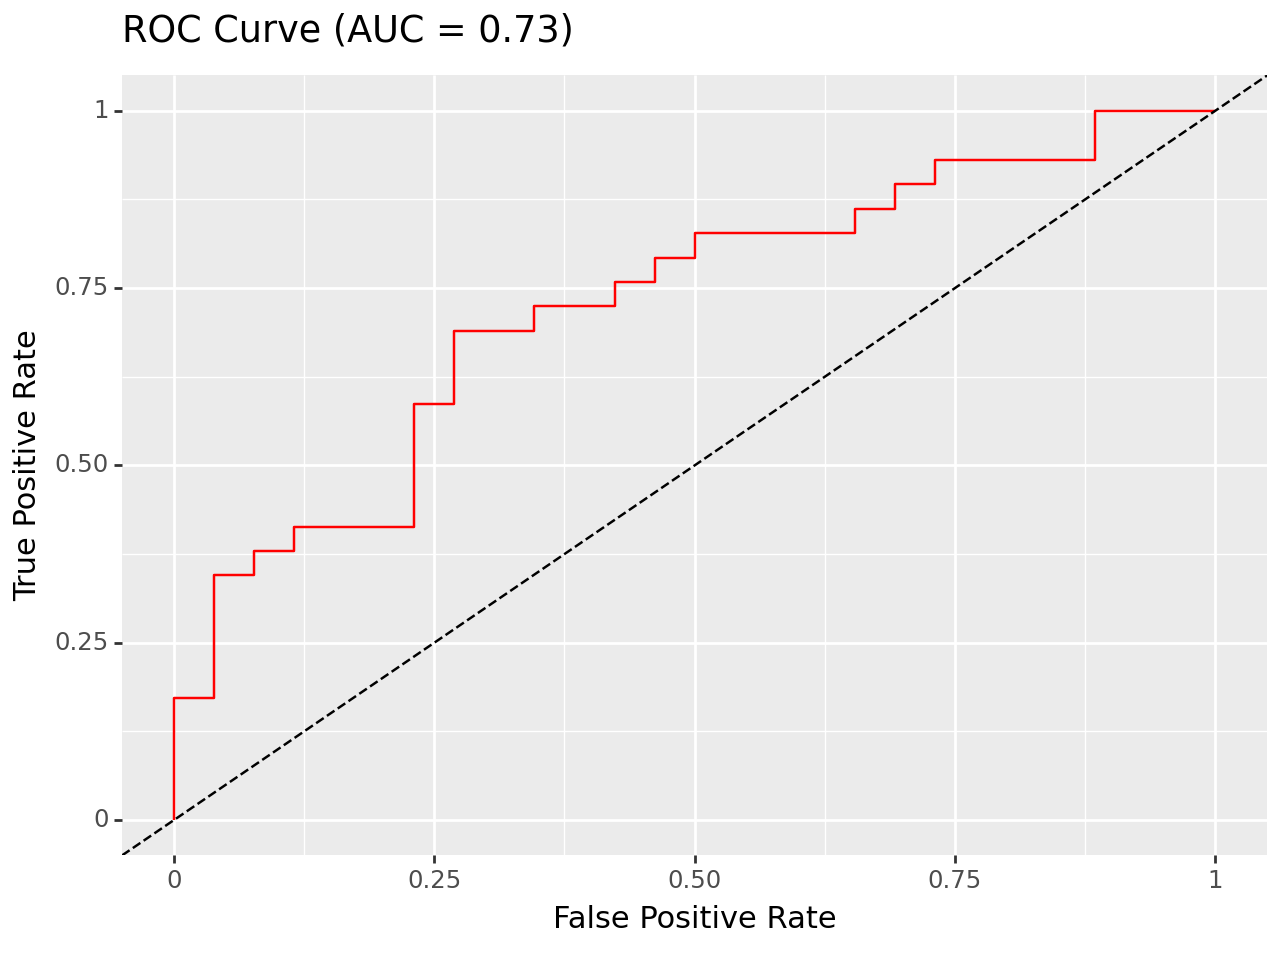

In [146]:
# Logistic Regression ROC Curve
y_pred_prob = lr_pipeline.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_pred_prob)
lr_roc_auc = auc(lr_fpr, lr_tpr)
lr_roc_data = pd.DataFrame({'FPR': lr_fpr, 'TPR': lr_tpr})

# Plot Curve
lr_roc_plot = (
    ggplot(lr_roc_data, aes(x='FPR', y='TPR')) +
    geom_line(color="red") +
    geom_abline(linetype='dashed') +
    labs(title='ROC Curve (AUC = {})'.format(round(lr_roc_auc, 2)), x='False Positive Rate', y='True Positive Rate')
)

print(lr_roc_plot)

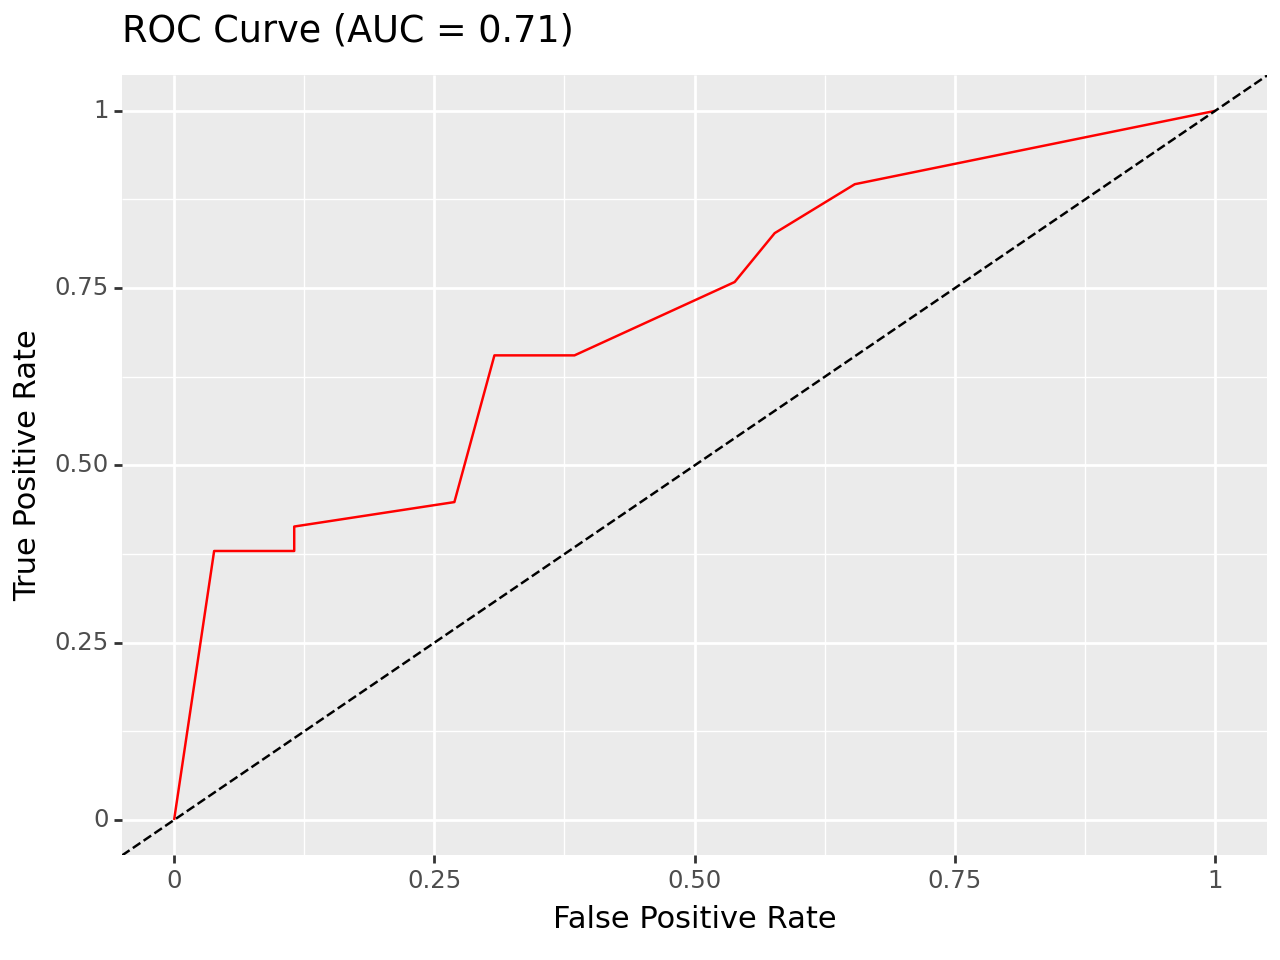

In [147]:
# Decision Tree ROC Curve
y_pred_prob = dt_pipeline.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, y_pred_prob)
dt_roc_auc = auc(dt_fpr, dt_tpr)
dt_roc_data = pd.DataFrame({'FPR': dt_fpr, 'TPR': dt_tpr})

# Plot Curve
dt_roc_plot = (
    ggplot(dt_roc_data, aes(x='FPR', y='TPR')) +
    geom_line(color="red") +
    geom_abline(linetype='dashed') +
    labs(title='ROC Curve (AUC = {})'.format(round(dt_roc_auc, 2)), x='False Positive Rate', y='True Positive Rate')
)

print(dt_roc_plot)

***Part Two: Metrics***

Consider the following metrics:

* True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

* Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

* True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [148]:
tpr_scorer = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)
accuracy_scorer = make_scorer(accuracy_score)

# Custom scorer for True Negative Rate (Specificity)
def tnr_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

tnr_scorer = make_scorer(tnr_score)

models = {
    'KNN': knn_pipeline,
    'Logistic Regression': lr_pipeline,
    'Decision Tree': dt_pipeline
}

results = []

for name, model in models.items():
    predicted = cross_val_predict(model, X, y, cv=5)
    tpr = cross_val_score(model, X, y, cv=5, scoring=tpr_scorer).mean()
    precision = cross_val_score(model, X, y, cv=5, scoring=precision_scorer).mean()
    tnr = cross_val_score(model, X, y, cv=5, scoring=tnr_scorer).mean()
    accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()

    results.append({'Model': name, 'Sensitivity': tpr, 'Precision': precision, 'Specifity': tnr, 'Accuracy': accuracy})

results_table = pd.DataFrame(results)
results_table

,Model,Sensitivity,Precision,Specifity,Accuracy
0,KNN,0.807816,0.767638,0.715385,0.765320
1,Logistic Regression,0.822069,0.792876,0.747077,0.787475
2,Decision Tree,0.780690,0.754762,0.708308,0.747340


***Part Three: Discussion***

Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

* Which metric(s) you would use for model selection and why.

* Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

* What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

**Q1**

**The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.**

What the hospital is trying to avoid here is false negatives, telling patients their low risk, then the same patients having a heart attack.  In this situation, sensitivity is the the most important metric, with higher sensitivity meaning that the model is good at identifying patients who are likely to experirnce heart attacks.  Based on my results, The best model in terms of sensitivity is the logistic regression model with sensitivty of 0.822.  

**Q2**

**The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.**

In this case, they want to have the highest precision to ensure that the patients they admit are actually high risk.  For this the metric they would want to select the logistic regression model again with the highest precision of 0.793.

**Q3**

**The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.**

For this situation, the hospital would get the most value out of using the decision tree classifier, as it is the most helpful in providing level of importance for the biological measures associated with heart attack risk.  Unfortunately none of these metrics above would help us with this issue.

**Q4**

**The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.**

To compare the new doctor's diagnoses to predictions given by the algorithm, you would want to use the accuracy metric.  Although it was not asked of us to create this metric I went back and added it to the dataframe.  We would want to use the model with the best accuracy which would once again be logistic regression with accuracy of 0.787.

***Part Four: Validation***

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [149]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
X_validation = ha_validation.drop('output', axis=1)
y_validation = ha_validation['output']

In [150]:
y_knn_pred_validation = knn_pipeline.predict(X_validation)
knn_cm_validation = confusion_matrix(y_validation, y_knn_pred_validation)
print("KNN Validation Confusion Matrix:")
print(knn_cm_validation)

KNN Validation Confusion Matrix:
[[10  1]
 [ 6 13]]


In [165]:
knn_auc_validation=cross_val_score(knn_pipeline, X_validation, y_validation, cv=5, scoring='roc_auc').mean()
knn_auc_validation

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_available_if.py", line 32, in __get__
    if not self.check(obj):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 46, in check
    getattr(self._final_estimator, attr)
AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File

nan

Unable to find ROC AUC for this, as my n_samples (24) is less than my n_neighbors (90).  This pipeline just doesn't work for this small of a set of data.

In [152]:
precision_knn_validation=precision_score(y_validation, y_knn_pred_validation, average='macro')
print('KNN Validation Precision:', precision_knn_validation)

KNN Validation Precision: 0.7767857142857143


In [153]:
recall_knn_validation=recall_score(y_validation, y_knn_pred_validation, average='macro')
print('KNN Validation Recall:', recall_knn_validation)

KNN Validation Recall: 0.7966507177033493


In [154]:
y_lr_pred_validation = lr_pipeline.predict(X_validation)
lr_cm_validation = confusion_matrix(y_validation, y_lr_pred_validation)
print('Logistic Regression Validation Confusion Matrix:')
print(lr_cm_validation)

Logistic Regression Validation Confusion Matrix:
[[ 9  2]
 [ 5 14]]


In [170]:
lr_auc_validation=cross_val_score(lr_pipeline, X_validation, y_validation, cv=5, scoring='roc_auc').mean()
print('Logistic Regression Validation ROC AUC:', lr_auc_validation)

Logistic Regression Validation ROC AUC: 0.8027777777777778


In [162]:
precision_lr_validation=precision_score(y_validation, y_lr_pred_validation, average='macro')
print('Logistic Regression Validation Precision:', precision_lr_validation)

Logistic Regression Validation Precision: 0.7589285714285714


In [159]:
recall_lr_validation=recall_score(y_validation, y_lr_pred_validation, average='macro')
print('Logistic Regression Validation Recall:', recall_lr_validation)

Logistic Regression Validation Recall: 0.777511961722488


In [166]:
y_dt_pred_validation = dt_pipeline.predict(X_validation)
dt_cm_validation = confusion_matrix(y_validation, y_dt_pred_validation)
print('Decision Tree Validation Confusion Matrix:')
print(dt_cm_validation)

Decision Tree Validation Confusion Matrix:
[[10  1]
 [ 6 13]]


In [169]:
dt_auc_validation=cross_val_score(dt_pipeline, X_validation, y_validation, cv=5, scoring='roc_auc').mean()
print('Decision Tree Validation ROC AUC:', dt_auc_validation)

Decision Tree Validation ROC AUC: 0.725


In [164]:
precision_dt_validation=precision_score(y_validation, y_dt_pred_validation, average='macro')
print('Decision Tree Validation Precision:', precision_dt_validation)

Decision Tree Validation Precision: 0.7767857142857143


In [167]:
recall_dt_validation=recall_score(y_validation, y_dt_pred_validation, average='macro')
print('Decision Tree Validation Recall:', recall_dt_validation)

Decision Tree Validation Recall: 0.7966507177033493


For each validation set, the confusion matrixes were completely different to the cross-validated estimates from part one, which is expected as there are different numbers of observations.  When comparing ROC AUC values, they weren't as high as the values from part one, but that was expected.  They overall performed well on the validation sets though, with the logistic regression model still performing the best.  Interstingly, the precision score for the logistic regression model on the validation set was the lowest of the 3, with the KNN model and the decision tree performing almost identically for precision.  The same was true for the recall of the KNN model and the decision tree as they both outperformed the logistic regression model with about the same score.  Overall, the models all performed well on the validation set.

***Part Five: Cohen’s Kappa***

Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [172]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_scorer=make_scorer(cohen_kappa_score)
cohen_kappa_knn=cross_val_score(knn_pipeline, X, y, cv=5, scoring=cohen_kappa_scorer).mean()
cohen_kappa_lr=cross_val_score(lr_pipeline, X, y, cv=5, scoring=cohen_kappa_scorer).mean()
cohen_kappa_dt=cross_val_score(dt_pipeline, X, y, cv=5, scoring=cohen_kappa_scorer).mean()
print('KNN Cohen Kappa score:', cohen_kappa_knn)
print('Logistic Regression Cohen Kappa score:', cohen_kappa_lr)
print('Decision Tree Cohen Kappa score:', cohen_kappa_dt)

KNN Cohen Kappa score: 0.5257983754020101
Logistic Regression Cohen Kappa score: 0.5711567928843296
Decision Tree Cohen Kappa score: 0.49067179906781444


A reason that one may use the Cohen Kappa metric over the others is that it's useful in situations where you want to account for the possibility of agreement happening by chance.  My conclusions from above do not change as the logistic regression model still has the highest Cohen Kappa score of the 3 models.